In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from minisom import MiniSom
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

rng = np.random.RandomState(42)

In [34]:
# Load data
train_df = pd.read_csv("Tables/bnpl_train.csv")
test_df = pd.read_csv("Tables/bnpl_test.csv")
val_df = pd.read_csv("Tables/bnpl_val.csv")
target_col = "default_flag"

In [35]:
# quick data check
print(train_df.shape, test_df.shape, val_df.shape)
print(train_df.head(),test_df.head(), val_df.head())
print("Train nulls in target:", train_df["default_flag"].isna().sum())
print("Train class distribution:\n", train_df["default_flag"].value_counts(normalize=True))

(595, 14) (199, 14) (199, 14)
   external_repayment_loans  credit_card_interest_incidence  default_flag  \
0                         1                               0             0   
1                         0                               0             0   
2                         0                               0             0   
3                         0                               1             0   
4                         1                               1             0   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buyi

In [36]:
# Split features and target for each set
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
print("X_train shape:", X_train.shape, X_train.head())
print("y_train shape:", y_train.shape, y_train.head())
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]
print("X_test shape:", X_test.shape, X_test.head())
print("y_test shape:", y_test.shape, y_test.head())
X_val = val_df.drop(columns=[target_col])
y_val = val_df[target_col]
print("X_val shape:", X_val.shape, X_val.head())
print("y_val shape:", y_val.shape, y_val.head())

X_train shape: (595, 13)    external_repayment_loans  credit_card_interest_incidence  \
0                         1                               0   
1                         0                               0   
2                         0                               0   
3                         0                               1   
4                         1                               1   

   bnpl_usage_frequency  financial_stress_score  credit_limit_utilisation  \
0             -0.730258               -1.246089                 -1.746734   
1              1.319109                0.529472                 -0.222965   
2              0.408279                1.239697                  0.805578   
3             -1.641088                1.594809                 -0.184871   
4              0.408279                0.529472                 -1.556263   

   payment_delinquency_count  impulsive_buying_score  \
0                  -1.500097               -0.528311   
1                  -1

In [37]:
def som_size_heuristic(n_samples: int):
    """Pick a roughly square grid; total units ≈ 5 * sqrt(N_train)."""
    tu = int(max(4, round(5 * np.sqrt(max(1, n_samples)))))
    m = int(round(np.sqrt(tu)))
    n = max(2, int(round(tu / m)))
    return m, n

In [38]:
def fit_som(X_train, m=None, n=None, total_units=None, sigma='auto',
            learning_rate=0.5, neighborhood_function='gaussian',
            num_iteration='auto', random_state=42):
    """
    Fit a MiniSom on TRAIN ONLY.
    - Grid size: choose via (m, n) or total_units, else use heuristic.
    - sigma='auto' -> neighborhood radius starts at ~half the largest grid dim.
    - num_iteration='auto' -> ~10 * n_train updates (tweak if big).
    """
    X = np.asarray(X_train, dtype=float)
    n_samples, n_features = X.shape

    if m is None or n is None:
        if total_units is not None:
            m = int(round(np.sqrt(total_units)))
            n = max(2, int(round(total_units / m)))
        else:
            m, n = som_size_heuristic(n_samples)

    if sigma == 'auto':
        sigma = max(m, n) / 2.0
    if num_iteration == 'auto':
        num_iteration = 10 * n_samples

    som = MiniSom(x=m, y=n, input_len=n_features, sigma=sigma,
                  learning_rate=learning_rate,
                  neighborhood_function=neighborhood_function,
                  random_seed=random_state)
    som.random_weights_init(X)
    som.train_random(X, num_iteration)
    return som, (m, n)

In [39]:
def som_transform(som, grid_shape, X, one_hot=True, topk=3):
    """
    Turn any X into SOM features:
      - bmu_id, bmu_row, bmu_col
      - distances to the top-k closest units (d1..dk)
      - optional one-hot for bmu_id (adds m*n columns)
    """
    X = np.asarray(X, dtype=float)
    m, n = grid_shape
    num_units = m * n
    W = som.get_weights()  # (m, n, input_len)
    feats = []

    for x in X:
        r, c = som.winner(x)
        bmu_id = r * n + c

        diffs = W - x.reshape(1, 1, -1)
        dists = np.linalg.norm(diffs, axis=2).reshape(-1)  # (m*n,)
        order = np.argsort(dists)
        d_list = [dists[order[i]] for i in range(min(topk, len(order)))]

        row = [bmu_id, r, c] + d_list

        if one_hot:
            oh = np.zeros(num_units, dtype=float)
            oh[bmu_id] = 1.0
            row.extend(oh)

        feats.append(row)

    return np.asarray(feats, dtype=float)


In [40]:
def hstack_features(X, som_feats):
    """Concatenate original features with SOM features."""
    X_arr = np.asarray(X, dtype=float)
    return np.hstack([X_arr, som_feats])

In [41]:
# Fit the SOM on TRAIN ONLY
som, grid_shape = fit_som(
    X_train,
    m=None, n=None, total_units=None,     # or set total_units=100 for a 10x10-ish map
    sigma='auto',
    learning_rate=0.5,
    neighborhood_function='gaussian',
    num_iteration='auto',                 # ~10 * len(X_train). Lower if slow.
    random_state=42
)



In [42]:
# Transform all sets to get SOM features
som_train = som_transform(som, grid_shape, X_train, one_hot=True, topk=3)
som_val   = som_transform(som, grid_shape, X_val,   one_hot=True, topk=3)
som_test  = som_transform(som, grid_shape, X_test,  one_hot=True, topk=3)

In [43]:
# Stack original + SOM features
X_train_aug = hstack_features(X_train, som_train)
X_val_aug   = hstack_features(X_val,   som_val)
X_test_aug  = hstack_features(X_test,  som_test)

X_train_aug.shape, X_val_aug.shape, X_test_aug.shape

((595, 140), (199, 140), (199, 140))

In [44]:
# SOM diagnostics
m, n = grid_shape

qe = som.quantization_error(np.asarray(X_train, dtype=float))
try:
    te = som.topographic_error(np.asarray(X_train, dtype=float))
except AttributeError:
    te = None  # older MiniSom versions might not have this

hits = som.activation_response(np.asarray(X_train, dtype=float))  # shape (m, n)

print({
    "grid_shape": (m, n),
    "quantization_error": float(qe),
    "topographic_error": (float(te) if te is not None else "n/a"),
    "min_hits": int(hits.min()),
    "max_hits": int(hits.max()),
    "empty_units": int((hits == 0).sum()),
})


{'grid_shape': (11, 11), 'quantization_error': 2.713349673684394, 'topographic_error': 0.03361344537815126, 'min_hits': 0, 'max_hits': 27, 'empty_units': 5}


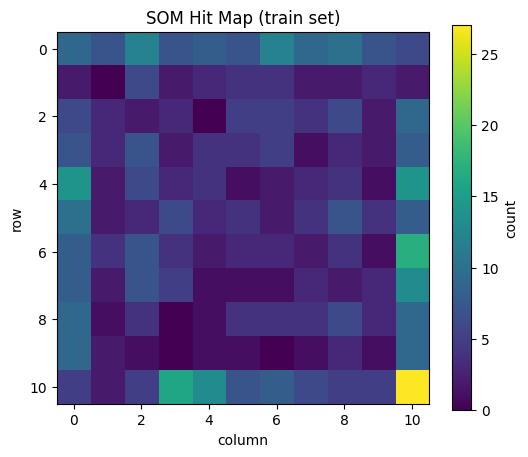

In [45]:
# Visualize the hit map
plt.figure(figsize=(6,5))
plt.title("SOM Hit Map (train set)")
plt.imshow(hits, interpolation="nearest")
plt.colorbar(label="count")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

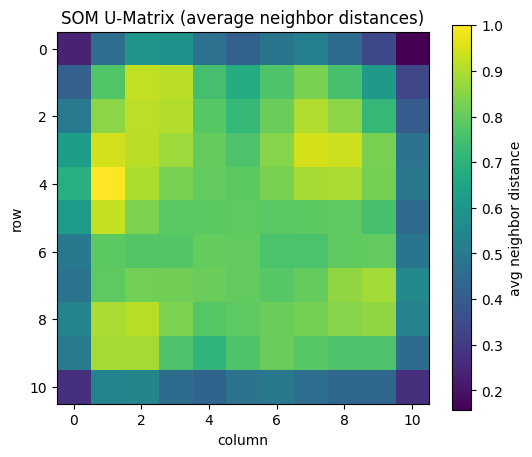

In [46]:
# Visualize the U-Matrix
umatrix = som.distance_map()  # shape (m, n), average neighbor distances
plt.figure(figsize=(6,5))
plt.title("SOM U‑Matrix (average neighbor distances)")
plt.imshow(umatrix, interpolation="nearest")
plt.colorbar(label="avg neighbor distance")
plt.xlabel("column"); plt.ylabel("row")
plt.show()

In [47]:
# Initialize and train a Random Forest on the augmented data
rf = RandomForestClassifier(
    n_estimators=400,         
    max_depth=None,            
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,                  
    random_state=42
)

rf.fit(X_train_aug, y_train)


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
#Evaluate the model on validation set
rf_val_proba = rf.predict_proba(X_val_aug)[:, 1]
rf_val_pred = (rf_val_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, rf_val_pred))
print("Precision:", precision_score(y_val, rf_val_pred))
print("Recall:", recall_score(y_val, rf_val_pred))
print("F1 Score:", f1_score(y_val, rf_val_pred))
print("ROC AUC:", roc_auc_score(y_val, rf_val_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, rf_val_pred))

Accuracy: 0.964824120603015
Precision: 1.0
Recall: 0.5625
F1 Score: 0.72
ROC AUC: 0.9935109289617486
Confusion Matrix:
 [[183   0]
 [  7   9]]


In [49]:
# Find optimal threshold based on F1 score
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_val, (rf_val_proba >= t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(scores)]
print("Best threshold:", best_t)


Best threshold: 0.29000000000000004


In [50]:
# Evaluate on test set using the best threshold
rf_test_proba = rf.predict_proba(X_test_aug)[:, 1]
rf_test_pred = (rf_test_proba >= best_t).astype(int)
print("Test set metrics at best threshold:")
print("Accuracy:", accuracy_score(y_test, rf_test_pred))
print("Precision:", precision_score(y_test, rf_test_pred))
print("Recall:", recall_score(y_test, rf_test_pred))
print("F1 Score:", f1_score(y_test, rf_test_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_test_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_test_pred))

Test set metrics at best threshold:
Accuracy: 0.9798994974874372
Precision: 0.9285714285714286
Recall: 0.8125
F1 Score: 0.8666666666666667
ROC AUC: 0.9832650273224044
Confusion Matrix:
 [[182   1]
 [  3  13]]


In [51]:
# Save results to JSON
fpr, tpr, thresholds = roc_curve(y_test, rf_test_pred)
results = {
    "threshold": float(best_t),
    "confusion_matrix": confusion_matrix(y_test, rf_test_pred).tolist(),
    "accuracy": accuracy_score(y_test, rf_test_pred),
    "precision": precision_score(y_test, rf_test_pred),
    "recall": recall_score(y_test, rf_test_pred),
    "f1_score": f1_score(y_test, rf_test_pred),
    "roc_auc": roc_auc_score(y_test, rf_test_pred),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results/SOM_RF_model_results.json", "w") as f:
    json.dump(results, f)

In [52]:
#Get the feature importance
som_x, som_y = som.get_weights().shape[:2]
n_nodes = som_x * som_y
N_DISTS = 3   

som_feature_names = (
    ['som_bmu_id', 'som_bmu_row', 'som_bmu_col'] +
    [f'som_d{i+1}' for i in range(N_DISTS)] +
    [f'som_oh_{i}' for i in range(n_nodes)]
)

# Save the final feature name list
feature_names = list(X_train.columns) + som_feature_names

# Check if name count is equal to number of importances
importances = rf.feature_importances_
if len(feature_names) != len(importances):
    raise ValueError(
        f"Feature-name count ({len(feature_names)}) != RF importances length ({len(importances)}). "
        "Ensure you included exactly the SOM features used during training, in the same order."
    )

# Get the importance table
feature_importance = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
      .sort_values('Importance', ascending=False)
      .reset_index(drop=True)
)
feature_importance.head(6).to_csv("Results/som_rf_feature_importance.csv", index=False) 


SOM + XGBoost Model


In [53]:
# Initialize the baseline XGBoost
xgb = XGBClassifier(
    n_estimators=1000,  
    learning_rate=0.05, 
    max_depth=6,        
    subsample=0.9,      
    colsample_bytree=0.9,
    reg_lambda=1.0,               
    objective="binary:logistic",
    n_jobs=-1,
    tree_method="hist",         
    random_state=42,
    eval_metric="auc"
)

# Train the model on the training set 
# and validate on the validation set
xgb.fit(
    X_train_aug, y_train,
    eval_set=[(X_val_aug, y_val)],
    verbose=False
)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [54]:
#evaluate the model on validation and test sets
xgb_val_proba = xgb.predict_proba(X_val_aug)[:, 1]
xgb_val_pred = (xgb_val_proba >= 0.5).astype(int)

print("Validation set metrics at 0.5 threshold:")
print("Accuracy:", accuracy_score(y_val, xgb_val_pred))
print("Precision:", precision_score(y_val, xgb_val_pred))
print("Recall:", recall_score(y_val, xgb_val_pred))
print("F1 Score:", f1_score(y_val, xgb_val_pred))
print("ROC AUC:", roc_auc_score(y_val, xgb_val_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, xgb_val_pred))

Validation set metrics at 0.5 threshold:
Accuracy: 0.9899497487437185
Precision: 1.0
Recall: 0.875
F1 Score: 0.9333333333333333
ROC AUC: 1.0
Confusion Matrix:
 [[183   0]
 [  2  14]]


In [55]:
# Find optimal threshold based on F1 score
thresholds = np.linspace(0.01, 0.99, 99)
scores = [f1_score(y_val, (xgb_val_proba >= t).astype(int)) for t in thresholds]
xgb_best_t = thresholds[np.argmax(scores)]
print("Best threshold:", xgb_best_t)


Best threshold: 0.11


In [56]:
#Evaluate XGBoost on TEST at the chosen threshold 
xgb_test_proba = xgb.predict_proba(X_test_aug)[:, 1]
xgb_test_pred = (xgb_test_proba >= xgb_best_t).astype(int)

print("Test set metrics at best threshold:")
print("Accuracy:", accuracy_score(y_test, xgb_test_pred))
print("Precision:", precision_score(y_test, xgb_test_pred))
print("Recall:", recall_score(y_test, xgb_test_pred))
print("F1 Score:", f1_score(y_test, xgb_test_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_test_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_test_pred))


Test set metrics at best threshold:
Accuracy: 0.9849246231155779
Precision: 0.8823529411764706
Recall: 0.9375
F1 Score: 0.9090909090909091
ROC AUC: 0.9993169398907104
Confusion Matrix:
 [[181   2]
 [  1  15]]


In [57]:
fpr, tpr, thresholds = roc_curve(y_test, xgb_test_proba)
results = {
    "threshold": xgb_best_t,
    "confusion_matrix": confusion_matrix(y_test, xgb_test_pred).tolist(),
    "accuracy": accuracy_score(y_test, xgb_test_pred),
    "precision": precision_score(y_test, xgb_test_pred),
    "recall": recall_score(y_test, xgb_test_pred),
    "f1_score": f1_score(y_test, xgb_test_pred),
    "roc_auc": roc_auc_score(y_test, xgb_test_pred),
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "roc_thresholds": thresholds.tolist(),    
}
with open("Results/SOM_XGB_model_results.json", "w") as f:
    json.dump(results, f)

In [58]:
# Get the feature importance for XGBoost and SOM
som_x, som_y = som.get_weights().shape[:2]
n_nodes = som_x * som_y
N_DISTS = 3  

som_feature_names = (
    ['som_bmu_id', 'som_bmu_row', 'som_bmu_col'] +
    [f'som_d{i+1}' for i in range(N_DISTS)] +
    [f'som_oh_{i}' for i in range(n_nodes)]
)

# Get the inal feature name list
feature_names = list(X_train.columns) + som_feature_names

#Check if name count is equal to number of features
importances = xgb.feature_importances_
if len(feature_names) != len(importances):
    raise ValueError(
        f"Feature-name count ({len(feature_names)}) != xgb importances length ({len(importances)}). "
        "Ensure you included exactly the SOM features used during training, in the same order."
    )

# Get the importance table
feature_importance = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
      .sort_values('Importance', ascending=False)
      .reset_index(drop=True)
)
feature_importance.head(6).to_csv("Results/som_xgb_feature_importance.csv", index=False)
feature_importance.head(6)


,Feature,Importance
0,bnpl_usage_frequency,0.241103
1,payment_delinquency_count,0.230095
2,stress_usage_interaction,0.108974
3,bnpl_debt_ratio,0.091916
4,financial_stress_score,0.077870
5,credit_limit_utilisation,0.067987
